In [1]:
runlist=[1400]
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.root'

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

from mu2etools import *
from mu2etools import wideband
np.set_printoptions(precision=2)

In [2]:
processor = wideband.DataProcessor(fixtimes=False, runlist=runlist, userunlist=True, remove=False, 
                                   treename='run', filter_name=["time", "fitStatus", "PEsTemperatureCorrected"])
arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree

In [3]:
#Calculate PEsSum per FEB and put it in array
arr['PEsSum'] = ak.sum(arr['PEsTemperatureCorrected'], axis=-1)
#Require that all FEBs are above 300 PEs
cut = ak.all(arr['PEsSum']>300., axis=-1)
arr_shower = arr[cut]
arr_shower = ak.nan_to_none(arr_shower)

In [4]:
#Mask pulses with bad PEs and low PE
arr_shower['time'] = ak.mask(arr_shower['time'], arr_shower["PEsTemperatureCorrected"]>6)
arr_shower['time'] = ak.mask(arr_shower['time'], arr_shower["fitStatus"]==1)

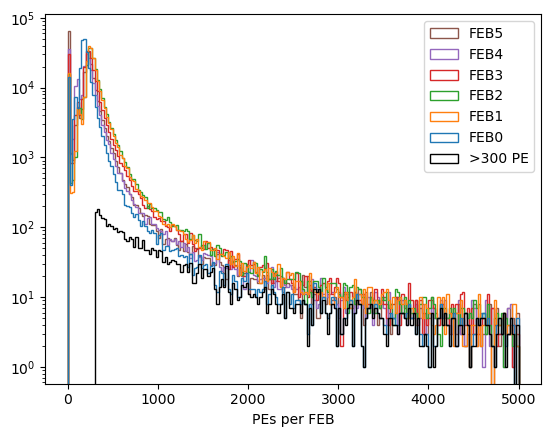

In [9]:
label=['FEB%d' % (feb) for feb in range(6)]
plt.hist(arr['PEsSum'], range=(0,5000), bins=200, histtype='step', label=label);
plt.hist(arr_shower['PEsSum'][:,0], range=(0,5000), bins=200, color='k', histtype='step', label=">300 PE");

plt.legend()
plt.yscale('log')
plt.xlabel("PEs per FEB");

array([ 0.  ,  0.27, -0.13,  3.45,  2.6 ,  3.07])

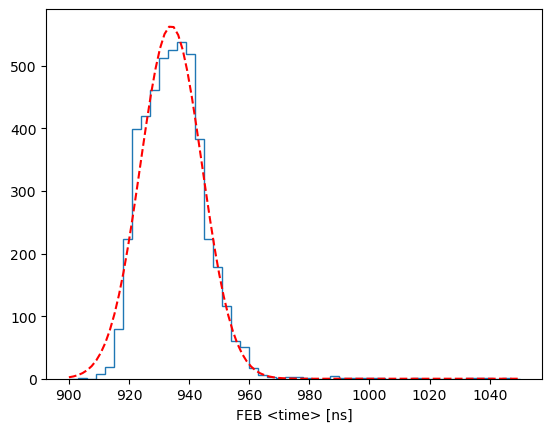

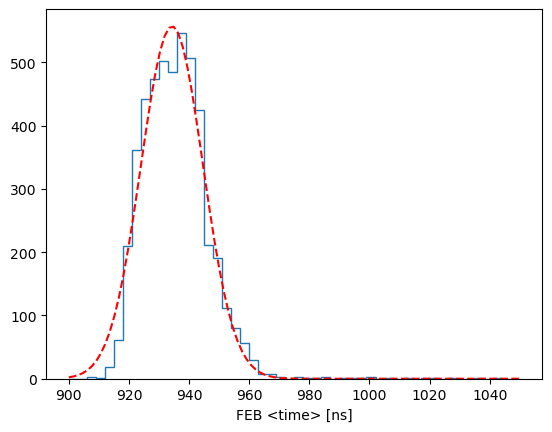

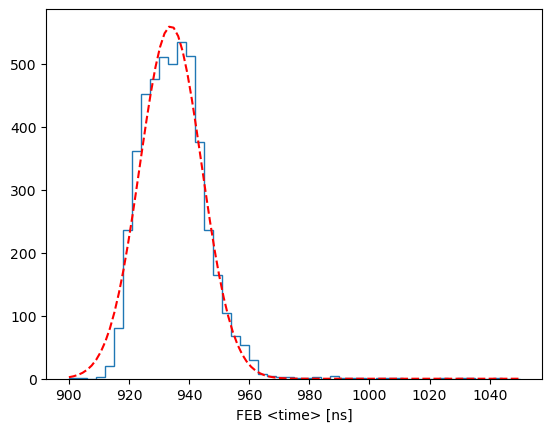

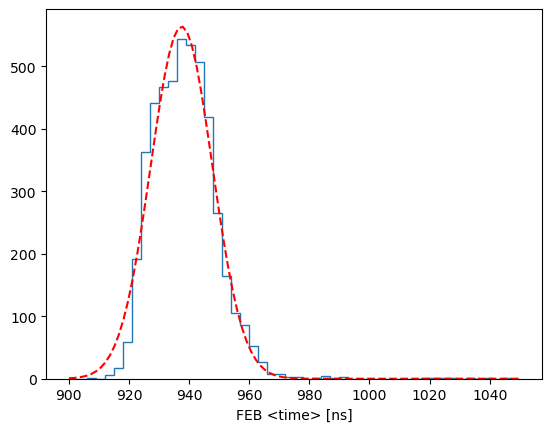

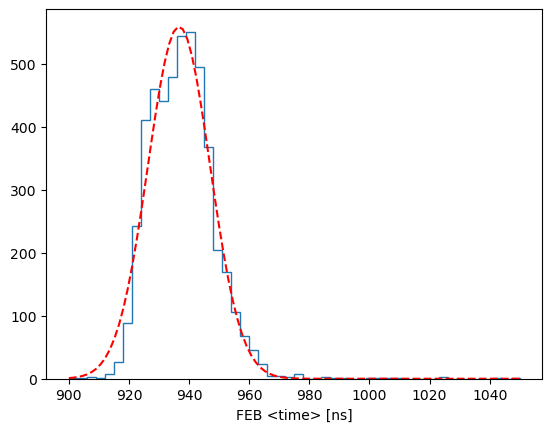

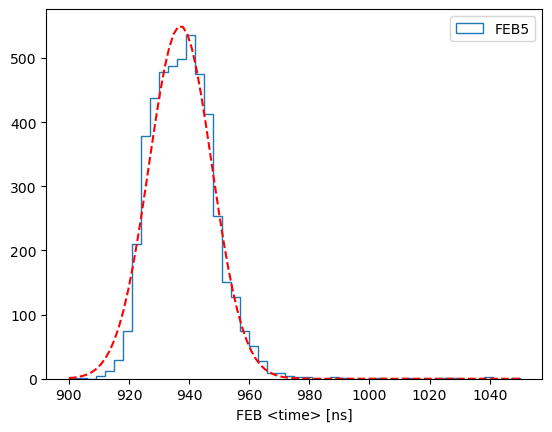

In [7]:
time_offsets=[]
for feb in range(6):
    plt.figure()
    #Take a mean by FEB
    arr_ = arr_shower['time'][:,feb]
    x=ak.mean(arr_, axis=-1)
    mean_fit = -1
    hist, bins, _ = plt.hist(x, histtype='step', range=(900, 1050), bins=50, 
                             label='FEB%d'%feb);    
    # Calculate the bin centers, mean...
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_widths = bin_centers[1] - bin_centers[0]
    hist_mean = np.sum(hist * bin_centers) / np.sum(hist)
    hist_max = max(hist)
    hist_std = np.sqrt(np.sum(hist * (bin_centers - hist_mean)**2) / (len(x) * bin_widths))
    integral = np.sum(hist * bin_widths)
    # Perform Gaussian fit
    initial_guess = [hist_max, hist_mean, hist_std]  # Initial parameter guess
    params, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, mean_fit, stddev_fit = params
    # Generate the fitted Gaussian curve
    curve_x = np.linspace(bins[0], bins[-1], 100)
    curve_y = gaussian(curve_x, amplitude_fit, mean_fit, stddev_fit)    
    plt.plot(curve_x, curve_y, 'r--')
    plt.xlabel('FEB <time> [ns]')
    time_offsets.append(mean_fit)
    
plt.legend();
np.array(time_offsets-time_offsets[0])

Offsets between FEBs: [-0.31  0.43  1.17  1.91  2.66  3.4 ]


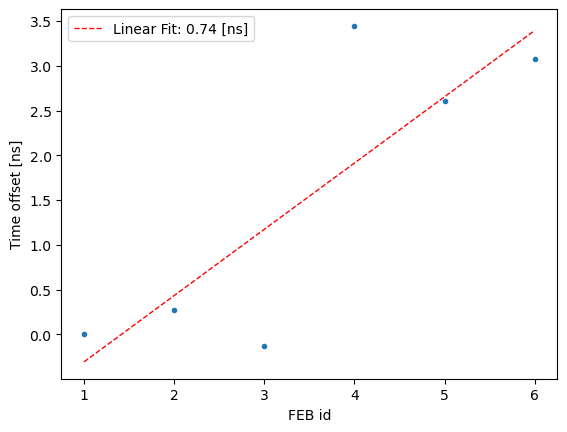

In [8]:
y=time_offsets-time_offsets[0]
x=range(1,len(y)+1)

plt.plot(x, y, '.');
m, b = np.polyfit(x, y, deg=1)

line = m * x + b
plt.plot(x, line, '--r', linewidth=1, label='Linear Fit: %0.2f [ns]'%m)
plt.xlabel('FEB id')
plt.ylabel("Time offset [ns]")

plt.legend();
print("Offsets between FEBs:", line)